In [3]:
import nltk
import re
import math
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import inaugural
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

In [4]:
# Create a class Bag of Words

class BoW:
    def __init__(self):
        # Here is where we keep all words. A set for faster lookup
        self.all_words = set()
        # Two dictionaries to map word to index and back. This helps 'encoding' and 'decoding' a BoW
        self.word_to_idx= {}
        self.idx_to_word= {}
        # The total number of words is just kept to aid starting the numpy array size, but can be inferred from all_words set.
        self.total_words = 0
        # A dictionary to save the words and their frequencies
        
    def fit_corpus(self, document):
        """
        Fits the BoW using the data. This is used to help the BoW learn the vocabulary and word indexes.
        """
        # Just checking if its empty or not
        if type(document) != list or len(document) <1 or type(document[0]) != str:
            raise TypeError("You must pass a list of strings for fitting.")
        list_of_words = document    
        # texts are already tokenized, so we just lower case them and add them to the set
        for word in list_of_words:
            word = word.lower()
            self.all_words.add(word)
        
        for idx, word in enumerate(self.all_words):
            # Set the mapping indexes.
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
            
        # Set the vocab size.
        self.total_words = len(self.all_words)
    
    def transform_corpus(self, data):
        """
        Transforms the input data into the BoW model format.
        """
        # Check that the model is fit.
        if self.total_words == 0:
            raise AttributeError("You must first fit the data.")
        if type(data[0]) == str:
            transformed = self._transform_single(data)   
        else:
            raise TypeError("You must pass a list of strings.")
        return transformed
    
    def fit_transform(self, data):
        """
        Does both fitting and transforming at once.
        """
        self.fit(data)
        return self.transform(data)

    def _transform_single(self, list_of_words):
        """
        Auxiliary method for simplifying the process of transforming. Here is where the "magic" happens.
        """
        # Start a zero filled array with the size of the vocabulary.
        transformed = np.zeros(self.total_words)
        n_counter = 0
        for word in list_of_words:
            # Iterate over sentence words checking if they are in the vocabulary.
            if word in self.all_words:
                n_counter += 1
                word_idx = self.word_to_idx[word]
                # Change the value of that specific index, by increasing the value.
                transformed[word_idx]+= 1
        
        for i in range(0,len(transformed)):
            transformed[i] = (transformed[i]+1) / (n_counter + self.total_words)
        return transformed
    
    def text_to_dict(self, data):
        """This function transforms a smoothed array from a text into a 
        dictioanry. Words as keyes and smoothed freq as values."""
        if type(data[0]) == np.float64:
            dictionary = {}
            for i in range(0,len(data)):
                word = self.idx_to_word[i]
                dictionary[word] = data[i]
            return dictionary
        else:
            raise TypeError("You must pass the output of bow.transform_corpus.")
    
    # My function to calculate pointwise KL divergence for filling the dictionary
    """This function calculates how many bits are needed for each word to model
    data set q with p"""
    def pointwise_kld(self, p, q):
        dictionary = {}
        for i in range(0,len(p)):
            pkld = p[i] * math.log2(p[i]/q[i])
            dictionary[self.idx_to_word[i]] = pkld
        return dictionary

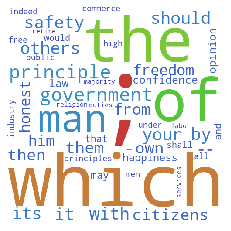

In [5]:
# Contruct the corpus and get it ready for Vectorization

''' This function prepares a corpus for the fit function in the BoW. It takes 
the inaugural corpus as argument and safes all the words in a list. Then it returns that 
list.'''
def prepare_corpus_for_fit(corpus):
    liste = []
    for i in inaugural.fileids():
        for k in inaugural.words(i):
            liste.append(k)
    return liste

corpus_for_fit = prepare_corpus_for_fit(inaugural)

# Since the nltk inaugural corpus does not contain the newest Inaugural Speech of Biden, 
# we extend the corpus for Biden's inagural speech manually.
with open('2021-Biden.txt', "r") as file:
    biden_text = []
    for line in file:
        splitted = line.strip() # delete new-line-symbols
        tokenized = word_tokenize(splitted) #tokanize line
        biden_text += tokenized #add line to list

# Safe final corpus in variable for fit
new_inaugural_corpus_for_fit = corpus_for_fit + biden_text 

# Prepare extended corpus for iteration, consisting of a list of lists. Every speech = 1 list.
# add all inaugural speeches to extended corpus list
old_speeches = []
for i in inaugural.fileids():
    speech = [k for k in inaugural.words(i)]
    old_speeches.append(speech)

# add Biden speech = inaugural_corpus[58]
new_inaugural_corpus = old_speeches + [biden_text] 

# test print first 10 words of Biden Speech
#print(new_inaugural_corpus[58][:10])

#test corpus stats
#print("total length: ", len(new_inaugural_corpus_for_fit))
#print("number of speeches: ", len(new_inaugural_corpus))
#print("speech length: ", len(new_inaugural_corpus[58]))

  



######### TESTING ############
bow = BoW()
bow.fit_corpus(new_inaugural_corpus_for_fit) # transforms new corpus to array

# Safe texts in arrays
arrays = [bow.transform_corpus(speech) for speech in new_inaugural_corpus]


##### Visualisation with wordclouds ######
# Get arrays into dictionaries -> key=word, value=pointwise kld
# The function to calculate the pointwise kld is inside the bow class

array_Washington = arrays[0]
array_Washington2 = arrays[1]
array_Harrison = arrays[13]
array_Obama = arrays[55]
array_Biden = arrays[58]
#print(arrays)


# Define colours
# formatted string mit Platzhalter %d für eine ganze Zahl, die Berechnung in der Klammer wird dann dafür eingesetzt.
# Der pointwise KLD Wert für jedes Wort wird mit Dreisatz von Bereich 0 bis 0.01 auf Breich 0 bis 250 umgerechnet.
# Falls KLD zu Beginn größer als 0.01, dann wäre das Ergebnis > 250, aber wird durch min auf 250 beschränkt. 
# Dadurch wird garantiert, dass die Berechnung ein Ergbnis zwischen 0 und 250 liefert.
# das Ergbnis der Berechnung wird durch "250 -" umgedreht, damit Rot die Farbe für die höchsten Werte ist.
# Farbstufen: >= 0.01 = HUE 0 (Rot), 0.008 = HUE 50 (Orange), 0.006 = HUE 100 (green), 0.004 = HUE 150 (Cyan), 
# 0.002 = HUE 200 (Blue), 0 = HUE 250 (Purple)

def my_tf_color_func(word, **kwargs):
    return "hsl(%d, 55%%, 50%%)" % (250 - min((wordcloud_dict[word] / 0.01 * 250), 250))

# Get dictionary for word cloud from pointwise kld function when modelling P with Q
wordcloud_dict = bow.pointwise_kld(arrays[3],arrays[58])

# set up word cloud parameters
wordcloud = WordCloud(background_color="white",width=500,height=500,max_words=50, color_func=my_tf_color_func, relative_scaling=0.5,normalize_plurals=False).generate_from_frequencies(wordcloud_dict)

# display word cloud
plt.axis("off")
plt.imshow(wordcloud)

wordcloud.to_file('images/wordcloud_kld(Jefferson-Biden51).png')


In [6]:
# print the 50 most distinctive words 
def most_distinct(number):
    import queue
    counter = 0
    
    pq = queue.PriorityQueue()
    for word, count in wordcloud_dict.items():
        pq.put((-count, word)) # pq requires a TUPLE!!!

    while counter < int(number):
        print(pq.get())
        counter +=1

#most_distinct(60)

In [7]:
# Overview of the most distinctive words 
# universal taggs:
# ADJ = adjective
# ADP = adposition (on, of, at, with, by, into, under)
# ADV = adverb
# CONJ = conjunction (and, or, but, if, while, although)
# DET = determiner
# NOUN = noun
# NUM = numeral (twenty-four, fourth, 1991, 14:24)
# PRT = particle
# PRON = pronoun
# VERB = verb
# . = punctuation marks
# x = other (z.b. dunno, gr8, typos)

from collections import defaultdict 
import queue
counter = 0
word_list = str()
pq = queue.PriorityQueue()
for word, count in wordcloud_dict.items():
    pq.put((-count, word)) # pq requires a TUPLE!!!

while counter < 50:
    distinct_tuple = pq.get()
    word_list += distinct_tuple[1] + ' '
    counter +=1

text = word_tokenize(word_list)
tagged_text = nltk.pos_tag(text, tagset='universal')

p = defaultdict(int)
for pos in tagged_text:
    p[pos[1]] = p[pos[1]] +1

#print(p)

In [7]:
# Print length for each speech in the corpus
def corpus_length(corpus):
    for i in range(0,len(corpus)):
        print("No.", i,'- tokens:', len(corpus[i]))

#corpus_length(extended_corpus)

In [28]:
#find average sent_legth with spaCy for
# 1789-Washington
# 1841-Harrison speech index 13
# and 2021-Biden speech index 58

import spacy
nlp = spacy.load('en_core_web_sm')

# calculate average sentence length for Inaugural Speech
def avg_sent_length(speech_index):
    text = ' '.join(new_inaugural_corpus[speech_index]) # set up text in string format
    doc = nlp(text) # transform text to doc

    no_sents = sent_counter(doc)
    no_tokens = len(doc)
    
    return round(no_tokens / no_sents , 1)
    

def sent_counter(doc):
    counter = 0
    for sent in doc.sents:
        counter += 1    
    return counter

print("1789-Washington", avg_sent_length(0))
print("1841-Harrison", avg_sent_length(13))
print("2021-Biden", avg_sent_length(58))

1789-Washington 66.9
1841-Harrison 42.5
2021-Biden 13.1


In [27]:
# Function to compute kl divergence
def kl_divergence(p,q):
    summe = 0
    for i in range(0,len(p)):
        p_kld = p[i] * math.log2(p[i]/q[i])
        summe += p_kld
    return summe

# Fuction to display KDL in both directions
def display_kld_both_directions(p,q):
    # calculate (P || Q)
    kl_pq = kl_divergence(p, q)
    # calculate (Q || P)
    kl_qp = kl_divergence(q, p)
    # return (kl_pq, kl_qp)
    return ('KL(P || Q): %.3f bits' % kl_pq,
            'KL(Q || P): %.3f bits' % kl_qp)

# Compare KLD in both directions with my own function
def compare_kl_divergence(all_arrays, speech_index):
    counter = 0
    for i in all_arrays:
        print("index: ", counter, "-", display_kld_both_directions(all_arrays[speech_index], i))
        counter += 1

print(compare_kl_divergence(arrays, 58))

######### PLOTTING #########

# compute kld in both directions. Return a list that can be used for plotting

'''This function takes as arguments the list of all arrays and the index of the speech from which we want to calculate kld.'''
def get_kld_pq(all_arrays, speech_index):
    liste = []
    for i in all_arrays:
        liste.append(kl_divergence(all_arrays[speech_index], i))
    return liste

def get_kld_qp(all_arrays, speech_index):
    liste = []
    for i in all_arrays:
        liste.append(kl_divergence(i, all_arrays[speech_index]))
    return liste

#print(get_kld_pq(arrays, 0))
#plot_pq_qp(get_kld_pq(arrays, 56), get_kld_qp(arrays, 56)) 

##### PLOTTING ##### GRAPH
#get_kld_pq = a list of all klds between the speech of the chosen index and all other speeches in the corpus

def plot_pq_qp_graph(pq, qp):
    # data to plot
    klds_pq = pq
    klds_qp = qp
    n_groups = len(pq)

    # create plot

    x= np.arange(n_groups)
    y= klds_pq
    z= klds_qp

    #plt.scatter(x, y)
    plt.figure(figsize = (10,5))
    plt.plot(x, y, marker = '.', color= 'orange', label = 'P || Q (PAST)')
    plt.plot(x,z, marker = '.', color = 'green', label = 'Q || P (FUTURE)')
    plt.title("KLD of inaugural addresses in diachrony")
    plt.xlabel("2021-Biden || Q  vs.  Q || 2021-Biden")
    plt.ylabel("KL Divergence")
    plt.xlim(0,61)
    plt.ylim(0)
    plt.legend()
    #plt.savefig('images/kld_biden-all.png')
    plt.show()
    

#plot_pq_qp_graph(get_kld_pq(arrays, 58), get_kld_qp(arrays, 58))


index:  0 - ('KL(P || Q): 0.210 bits', 'KL(Q || P): 0.156 bits')
index:  1 - ('KL(P || Q): 0.408 bits', 'KL(Q || P): 0.204 bits')
index:  2 - ('KL(P || Q): 0.212 bits', 'KL(Q || P): 0.180 bits')
index:  3 - ('KL(P || Q): 0.163 bits', 'KL(Q || P): 0.142 bits')
index:  4 - ('KL(P || Q): 0.181 bits', 'KL(Q || P): 0.166 bits')
index:  5 - ('KL(P || Q): 0.207 bits', 'KL(Q || P): 0.149 bits')
index:  6 - ('KL(P || Q): 0.197 bits', 'KL(Q || P): 0.145 bits')
index:  7 - ('KL(P || Q): 0.196 bits', 'KL(Q || P): 0.200 bits')
index:  8 - ('KL(P || Q): 0.253 bits', 'KL(Q || P): 0.281 bits')
index:  9 - ('KL(P || Q): 0.208 bits', 'KL(Q || P): 0.209 bits')
index:  10 - ('KL(P || Q): 0.208 bits', 'KL(Q || P): 0.145 bits')
index:  11 - ('KL(P || Q): 0.189 bits', 'KL(Q || P): 0.140 bits')
index:  12 - ('KL(P || Q): 0.207 bits', 'KL(Q || P): 0.218 bits')
index:  13 - ('KL(P || Q): 0.406 bits', 'KL(Q || P): 0.504 bits')
index:  14 - ('KL(P || Q): 0.259 bits', 'KL(Q || P): 0.287 bits')
index:  15 - ('KL(P 

In [ ]:
# Create some corpus statistics and word counts

def statistics(index):
    they_count = 0
    their_count = 0
    he = 0
    him = 0
    she = 0
    her = 0
    men = 0
    man = 0
    women = 0
    woman = 0
    for i in extended_corpus[index]:
        if i == 'they' or i == 'They':
            they_count += 1
        if i == 'their' or i == 'Their':
            their_count += 1
        if i == 'he' or i == 'He':
            he += 1
        if i == 'him' or i == 'Him':
            him += 1
        if i == 'she' or i == 'She':
            she += 1
        if i == 'her' or i == 'Her':
            her += 1
        if i == 'men' or i == 'Men':
            men += 1
        if i == 'Man' or i == 'man':
            man += 1
        if i == 'women' or i == 'Women':
            women += 1
        if i == 'woman' or i == 'Woman':
            woman += 1
    return (str(index) + ";" + 
          str(they_count) + ";" + 
          str(their_count) + ";" +
          str(he) + ";" +
          str(him) + ";" +
          str(she) + ";" +
          str(her) + ";" +
          str(men) + ";" +
          str(man) + ";" +
          str(women) + ";" +
          str(woman) + "\n")    

# safe statistics in csv file 
with open('statistics.csv', "w") as file:
    
    # create header
    file.write("speech_no;they;their;he;him;she;her;men;man;women;woman\n")
    
    # Add content
    for i in range(0,len(extended_corpus)):
        file.write(statistics(i))